In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("→ Added to sys.path:", project_root)
print("→ cwd is:", os.getcwd())

from environments.realistic_env    import realisticAUVEnv
from agents.td3_agent              import TD3Agent
from utils.rl_utils                import *

→ Added to sys.path: /Users/eirikvarnes/code/auv-rl-project
→ cwd is: /Users/eirikvarnes/code/auv-rl-project/notebooks
pygame 2.6.1 (SDL 2.28.4, Python 3.11.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Static Environment (No Physics)

In [2]:
continuous_env = realisticAUVEnv(
    # ─── Map & observation ─────────────────────────────────────────
    grid_size          = (200, 200),
    resolution         = 0.05,
    docks              = 1,
    dock_radius        = 0.5,
    use_history        = True,
    history_length     = 4,
    window_size        = (800, 600),

    # ─── Physics ───────────────────────────────────────────────────
    mass               = 1.0,
    drag_coef          = 0.5,
    dt                 = 0.1,
    use_drag           = False,   # ignore drag forces
    use_inertia        = False,   # kinematic (no Newtonian integration)
    current_params     = None,    # no ocean current

    # ─── Action space ─────────────────────────────────────────────
    discrete_actions   = False,

    # ─── Reward scheme ────────────────────────────────────────────
    use_continuous_reward   = True,
    step_penalty            = -1.0,   # per-step cost in discrete mode
    slow_step_penalty       = 0.03,   # per-step cost in continuous mode
    action_penalty_coeff    = 0.1,    # cost ∝ |v|+|lat|+|ω|
    progress_coeff          = 8.0,    # reward ∝ distance closed
    collision_penalty       = -0.5,   # penalty on collision
    turn_penalty_coeff      = 0.1,    # cost ∝ |ω| each step
    dock_reward             = 100.0,  # terminal bonus on docking
)

# **Simple TD3 Agent**

TD3: 100%|██████████| 200/200 [01:53<00:00,  1.76it/s, Reward=-80.39]  


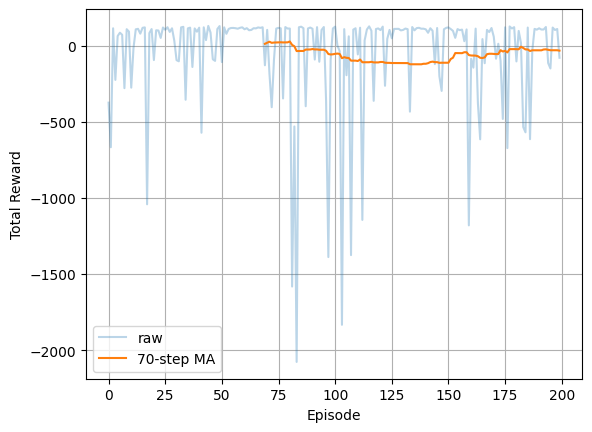

In [3]:
td3_agent = TD3Agent(continuous_env)

rewards = train_td3(continuous_env, td3_agent, episodes=200, max_steps=1000)

# plot the learning curve
plot_rewards(rewards, window=70)

In [4]:
sr, avg_steps = evaluate_agent(continuous_env, td3_agent, episodes=1000, max_steps=200)
print(f"Success rate: {sr*100:.1f}%, Avg steps: {avg_steps:.1f}")

Success rate: 79.8%, Avg steps: 109.0


In [5]:
record_headless(continuous_env, td3_agent, out_path="../gifs/td3_run.gif", max_steps=200, fps=10)

Headless recording saved to ../gifs/td3_run.gif


# **Enhanced TD3 Agent**

TD3: 100%|██████████| 100/100 [03:33<00:00,  2.13s/it, Rew=-88.29] 


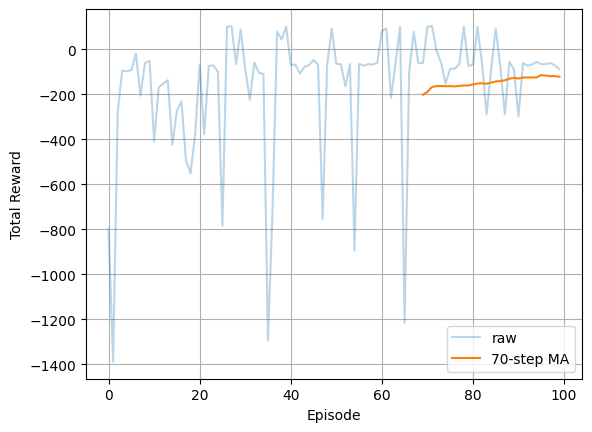

In [5]:
enhanced_td3_agent = TD3Agent(
    continuous_env,
    hidden_dims    = [128, 128, 64],  # or [64,64] to match your DQN
    actor_lr       = 3e-4,
    critic_lr      = 3e-4,
    gamma          = 0.99,
    tau            = 0.005,
    buffer_size    = 100_000,
    batch_size     = 128,
    policy_noise   = 0.2,
    noise_clip     = 0.5,
    policy_freq    = 2,
)

rewards = train_td3(continuous_env, enhanced_td3_agent, episodes=100, max_steps=1000)

# plot the learning curve
plot_rewards(rewards, window=70)

In [ ]:
sr, avg_steps = evaluate_agent(continuous_env, enhanced_td3_agent, episodes=1000, max_steps=500)
print(f"Success rate: {sr*100:.1f}%, Avg steps: {avg_steps:.1f}")

In [8]:
record_headless(continuous_env, enhanced_td3_agent, out_path="../gifs/enhanced_td3_run.gif", max_steps=1000, fps=10)

Headless recording saved to ../gifs/enhanced_td3_run.gif
